In [ ]:
# Reload the dataset
import pandas as pd

# Load the uploaded dataset
file_path = 'SADCQ_2023_clean_final.csv'
data = pd.read_csv(file_path)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Data preprocessing
# data_cleaned = data.drop(columns=['sitename'])  # Removing non-numerical and irrelevant columns
data_cleaned = data.copy()
data_cleaned = data_cleaned.dropna()  # Drop rows with missing values
mapping = {
      "q25": {1.0: "Yes", 2.0: "No", np.nan: "Null"},
      "q24": {1.0: "Yes", 2.0: "No", np.nan: "Null"},
      "q84":{
      1.0: "Never",
      2.0: "Rarely",
      3.0: "Sometimes",
      4.0: "Most of the time",
      5.0: "Always",
      np.nan: "Null",  # Handle NaN values
      },
      "q49":{
      1.0: "0 times",
      2.0: "1 or 2 times",
      3.0: "3 to 9 times",
      4.0: "10 to 19 times",
      5.0: "20 to 39 times",
      6.0: "40 or more times",
      np.nan: "Null",  # Handle NaN values
      },
      "q52":{
      1.0: "0 times",
      2.0: "1 or 2 times",
      3.0: "3 to 9 times",
      4.0: "10 to 19 times",
      5.0: "20 to 39 times",
      6.0: "40 or more times",
      np.nan: "Null",  # Handle NaN values
      },
      "q42":{
      1.0: "0 days",
      2.0: "1 or 2day",
      3.0: "3 to 5 days",
      4.0: "6 to 9 days",
      5.0: "10 to 19 days",
      6.0: "20 to 29 days",
      7.0: "All 30 days",
      np.nan: "Null",  # Handle NaN values
      },
      "q14":{
      1.0: "0 days",
      2.0: "1 day",
      3.0: "2 or 3 days",
      4.0: "4 or 5 days",
      5.0: "6 or more days",
      np.nan: "Null",
      },
      "grade": {
      1.0: "9th grade",
      2.0: "10th grade",
      3.0: "11th grade",
      4.0: "12th grade",
      5.0: "Ungraded or other grade",
      },
      "sex": {
      1.0: "Female",
      2.0: "Male"},
      "race7": {
      1.0: "American Indian/Alaska Native",
      2.0: "Asian",
      3.0: "Black or African American",
      4.0: "Hispanic/Latino",
      5.0: "Native Hawaiian/Other Pacific Islander",
      6.0: "White",
      7.0: "Multiple Races (Non-Hispanic)"},
      "age":{
          1.0: "12 years old or younger",
          2.0: "13 years old",
          3.0: "14 years old",
          4.0: "15 years old",
          5.0: "16 years old",
          6.0: "17 years old",
          7.0: "18 years old or older"
      } ,
      "qclose2people":{
          1.0: "Strongly agree",
      2.0: "Agree",
      3.0: "Not sure",
      4.0: "Disagree",
      5.0: "Strongly disagree",
      np.nan: "Null",
      }
      }
data_cleaned = data_cleaned.replace(mapping)
mapping2 = {
    "q25":"Q25 - Electronically bullied",
    "q24":"Q24 - School bullied",
    "q84":"Q84 - Mental health",
    "q49":"Q49 - Prescription pill",
    "q52":"Q52 - Heroin takein",
    "q42":"Q42 - Alcohol",
    "q14":"Q14 - School unsafe",
    "qclose2people":"Q - Close to people",
    "sex":"Sex",
    "race7":"Race",
    "grade":"Grade",
    "age":"Age",
    "sitename":"Location"
}
data_cleaned = data_cleaned.rename(columns=mapping2)
# data_cleaned.loc[data_cleaned['Label'] >=2, 'Label'] = 2

# Separate predictors and target
X = data_cleaned.drop(columns=['Label', 'weight'])
y = data_cleaned['Label']
weights = data_cleaned['weight']

# Encode categorical variables and scale numerical features
X_encoded = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
    X_scaled, y_encoded, weights, test_size=0.3, random_state=42
)

# 5-Fold Cross-Validation within the Training Set
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_importances = []
classification_reports = []

for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    train_weights_fold, val_weights_fold = train_weights.iloc[train_index], train_weights.iloc[val_index]

    # Train XGBoost Classifier
    xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train_fold, y_train_fold, sample_weight=train_weights_fold)

    # Collect feature importances
    feature_importances.append(xgb_model.feature_importances_)

    # Predict and evaluate
    y_pred = xgb_model.predict(X_val_fold)
    report = classification_report(
        y_val_fold, y_pred, target_names=label_encoder.classes_, output_dict=True, sample_weight=val_weights_fold
    )
    classification_reports.append(report)


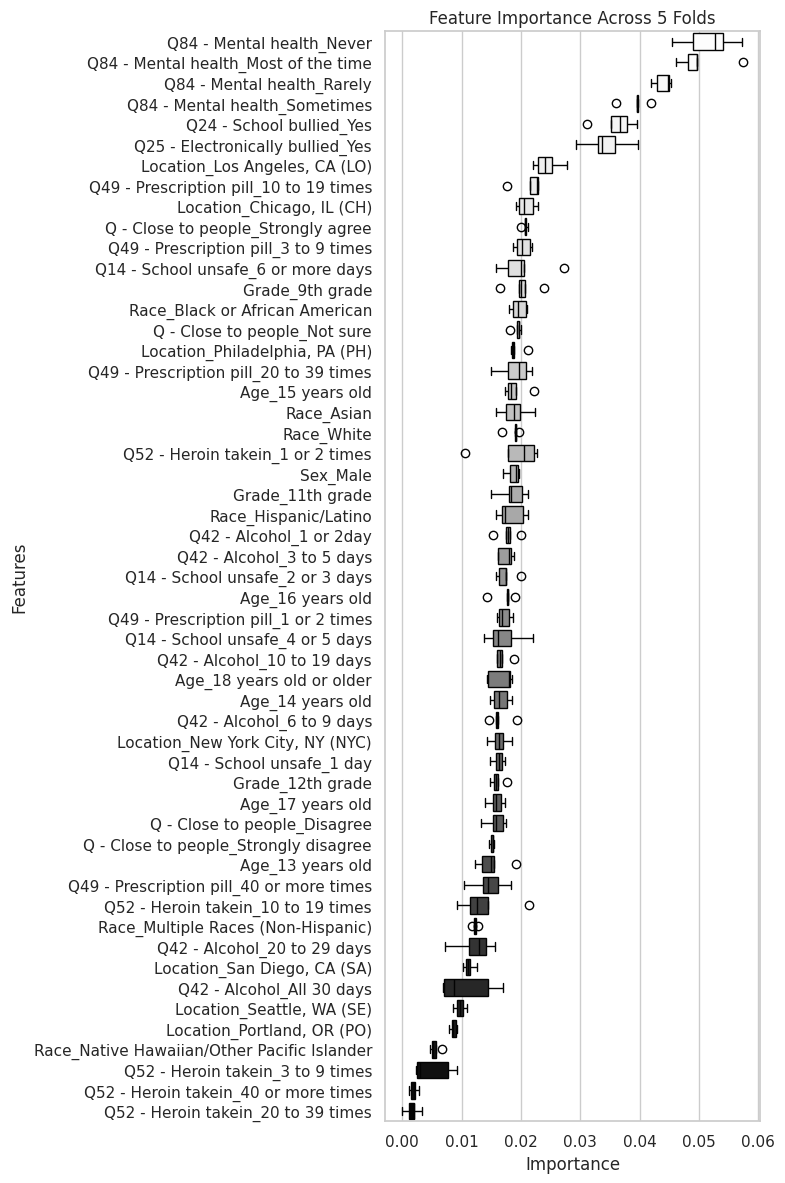

In [ ]:
feature_names = X_encoded.columns
# Aggregate feature importances and compute the mean importance across folds
feature_importances = np.array(feature_importances)
mean_importances = np.mean(feature_importances, axis=0)
sorted_indices = np.argsort(mean_importances)[::-1]  # Sort indices by descending importance
sorted_features = feature_names[sorted_indices]

# Prepare data for boxplot
feature_importances_sorted = pd.DataFrame(feature_importances[:, sorted_indices], columns=sorted_features)

sns.set_theme(style="whitegrid")
palette = sns.color_palette("Greys", len(sorted_features))

# Plot vertical boxplot for feature importances
plt.figure(figsize=(8, 12))
sns.boxplot(data=feature_importances_sorted, orient='h', palette=palette)  # Horizontal orientation for boxplot
plt.yticks(range(len(sorted_features)), sorted_features)  # Align y-ticks with sorted features
plt.title('Feature Importance Across 5 Folds')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

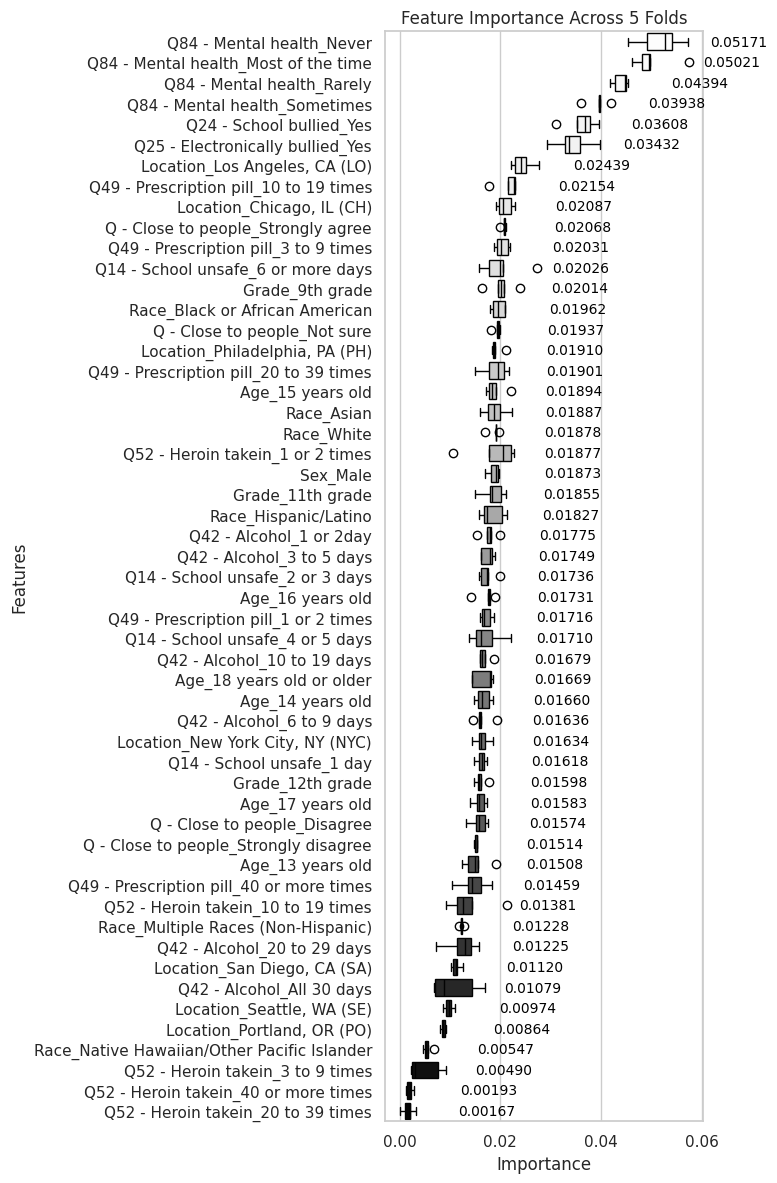

In [ ]:
# Plot vertical boxplot for feature importances with numerical values
plt.figure(figsize=(8, 12))
sns.boxplot(data=feature_importances_sorted, orient='h', palette=palette)  # Horizontal orientation for boxplot
plt.yticks(range(len(sorted_features)), sorted_features)  # Align y-ticks with sorted features
plt.title('Feature Importance Across 5 Folds')
plt.xlabel('Importance')
plt.ylabel('Features')

# Add numerical values (mean importance) to the plot
for i, importance in enumerate(mean_importances[sorted_indices]):
    plt.text(
        importance + 0.01,  # Slightly offset to the right of the boxplot
        i,  # Position aligned with the feature
        f"{importance:.5f}",  # Format to two decimal places
        va='center',  # Vertical alignment
        fontsize=10,  # Adjust font size
        color='black'  # Text color
    )

plt.tight_layout()
plt.show()

In [ ]:
# Aggregate classification reports
avg_report = {}

for key in classification_reports[0].keys():
    # Check if the value for the key is a dictionary or a scalar
    if isinstance(classification_reports[0][key], dict):
        # Aggregate nested metrics like precision, recall, etc.
        avg_report[key] = {
            metric: np.mean([
                report[key][metric] for report in classification_reports if key in report and metric in report[key]
            ])
            for metric in ['precision', 'recall', 'f1-score', 'support']
        }
    else:
        # Aggregate scalar metrics like accuracy
        avg_report[key] = np.mean([
            report[key] for report in classification_reports if key in report
        ])

# Separate scalar metrics and nested dictionary metrics
scalar_metrics = {key: value for key, value in avg_report.items() if isinstance(value, (int, float, np.float64))}
nested_metrics = {key: value for key, value in avg_report.items() if isinstance(value, dict)}

# Convert nested dictionary metrics to DataFrame
nested_metrics_df = pd.DataFrame.from_dict(nested_metrics, orient='index')

# Display scalar metrics separately
print("----------------------- Training -----------------------")
print("Scalar Metrics:")
for metric, value in scalar_metrics.items():
    print(f"{metric}: {value}")

print("\nDetailed Metrics (Nested):")
print(nested_metrics_df)
print('\n')


# Final Model Training on Full Training Data and Evaluation on Test Set
xgb_model_final = XGBClassifier(eval_metric='mlogloss', random_state=42)
xgb_model_final.fit(X_train, y_train, sample_weight=train_weights)

# Predict on Test Set
y_test_pred = xgb_model_final.predict(X_test)

# Test Set Evaluation
test_report = classification_report(
    y_test, y_test_pred, target_names=label_encoder.classes_, output_dict=True, sample_weight=test_weights
)

# Print Test Set Report
# Separate scalar metrics and nested dictionary metrics
scalar_metrics = {key: value for key, value in test_report.items() if isinstance(value, (int, float, np.float64))}
nested_metrics = {key: value for key, value in test_report.items() if isinstance(value, dict)}

# Convert nested dictionary metrics to DataFrame
nested_metrics_df = pd.DataFrame.from_dict(nested_metrics, orient='index')

# Display scalar metrics separately
print("----------------------- Testing -----------------------")

print("Scalar Metrics:")
for metric, value in scalar_metrics.items():
    print(f"{metric}: {value}")

print("\nDetailed Metrics (Nested):")
print(nested_metrics_df)

----------------------- Training -----------------------
Scalar Metrics:
accuracy: 0.8202221719617324

Detailed Metrics (Nested):
              precision    recall  f1-score      support
1              0.865721  0.954763  0.908024  41696.12856
2              0.212920  0.095764  0.131072   4788.49982
3              0.242338  0.108497  0.148061   3010.26986
macro avg      0.440326  0.386342  0.395719  49494.89824
weighted avg   0.765400  0.820222  0.786843  49494.89824


----------------------- Testing -----------------------
Scalar Metrics:
accuracy: 0.8340204030847473

Detailed Metrics (Nested):
              precision    recall  f1-score      support
1              0.873208  0.956922  0.913150   91727.3523
2              0.248048  0.105714  0.148248   10023.3130
3              0.359227  0.179088  0.239018    6066.8450
macro avg      0.493494  0.413908  0.433472  107817.5103
weighted avg   0.786168  0.834020  0.804108  107817.5103
